# PLINDER System Filtering Pipeline

This notebook filters PLINDER annotation data based on structural quality, experimental criteria, and interaction relevance to select meaningful protein-ligand systems for analysis.

## Filtering Criteria:
1. **Experimental Method**: X-ray crystallography only
2. **Bioassembly**: First bioassembly only
3. **Chain Limits**: ≤5 ligand chains, ≤5 protein chains
4. **Covalent Ligands**: Exclude systems with covalent ligands
5. **Ligand Types**: Exclude cofactors/oligopeptides/nucleotides/saccharides
6. **X-ray Validation**: Resolution, R-factors, coordinates, clashes, contacts
7. **Interaction Statistics**: 3-50 PLIP interactions, 5-100 pocket residues
8. **Molecular Weight**: 200-800 Da for largest ligand

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import OrderedDict

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


## Load Annotation Data

In [2]:
# Load the annotation table
annotation_path = Path('data/annotation_table.parquet')

if not annotation_path.exists():
    print(f"❌ File not found: {annotation_path}")
    print("Please ensure annotation_table.parquet is in the data/ directory")
else:
    df = pd.read_parquet(annotation_path)
    print(f"✓ Loaded annotation table: {annotation_path}")
    print(f"  Shape: {df.shape}")
    print(f"  Columns: {len(df.columns)}")
    print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

✓ Loaded annotation table: data/annotation_table.parquet
  Shape: (1357906, 743)
  Columns: 743
  Memory usage: 34998.08 MB


## Initial Data Overview

In [3]:
# Display initial statistics
print("="*80)
print("INITIAL DATA OVERVIEW")
print("="*80)
print(f"Total systems: {len(df):,}")
print(f"\nColumn names ({len(df.columns)}):")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:3d}. {col}")

print(f"\nFirst few rows:")
display(df.head(3))

print(f"\nData types summary:")
print(df.dtypes.value_counts())

# Initialize filtering statistics tracker
filtering_stats = OrderedDict()
filtering_stats['Initial'] = len(df)

INITIAL DATA OVERVIEW
Total systems: 1,357,906

Column names (743):
    1. entry_pdb_id
    2. entry_release_date
    3. entry_oligomeric_state
    4. entry_determination_method
    5. entry_keywords
    6. entry_pH
    7. entry_resolution
    8. entry_validation_resolution
    9. entry_validation_rfree
   10. entry_validation_r
   11. entry_validation_clashscore
   12. entry_validation_percent_rama_outliers
   13. entry_validation_percent_rota_outliers
   14. entry_validation_data_completeness
   15. entry_validation_percent_RSRZ_outliers
   16. entry_validation_atom_count
   17. entry_validation_molprobity
   18. entry_validation_mean_b_factor
   19. entry_validation_median_b_factor
   20. entry_validation_pdbx_resolution
   21. entry_validation_pdbx_reflns_resolution
   22. entry_validation_meanI_over_sigI_obs
   23. entry_validation_r_minus_rfree
   24. entry_pass_validation_criteria
   25. system_biounit_id
   26. system_protein_chains_asym_id
   27. system_id_no_biounit
   28. sy

,entry_pdb_id,entry_release_date,entry_oligomeric_state,entry_determination_method,entry_keywords,entry_pH,entry_resolution,entry_validation_resolution,entry_validation_rfree,entry_validation_r,...,system_ligand_has_fragment,system_ligand_has_oligo,system_ligand_has_artifact,system_ligand_has_other,system_ligand_has_covalent,system_ligand_has_invalid,system_ligand_has_ion,system_protein_chains_total_length,system_unique_ccd_codes,system_proper_unique_ccd_codes
0,3grt,1997-02-12,dimeric,X-RAY DIFFRACTION,OXIDOREDUCTASE,8.0,2.5,2.5,NaN,0.17,...,False,False,False,False,False,False,False,922,FAD,FAD
1,3grt,1997-02-12,dimeric,X-RAY DIFFRACTION,OXIDOREDUCTASE,8.0,2.5,2.5,NaN,0.17,...,False,True,False,False,False,False,False,922,TS2,TS2
2,3grt,1997-02-12,dimeric,X-RAY DIFFRACTION,OXIDOREDUCTASE,8.0,2.5,2.5,NaN,0.17,...,False,False,False,False,False,False,False,922,FAD,FAD



Data types summary:
object     541
float64    135
int64       42
bool        25
Name: count, dtype: int64


## Key Columns from PLINDER Documentation

Based on the PLINDER documentation (https://plinder-org.github.io/plinder/), here are the key columns we'll use:

### Entry-Level (PDB):
- `entry_pdb_id`: PDB ID
- `entry_determination_method`: Experimental method (e.g., "X-RAY DIFFRACTION")
- `entry_resolution`: Resolution in Angstroms
- `entry_rfree`: R-free factor
- `entry_r`: R-factor
- `entry_clashscore`: Clashscore
- `entry_oligomeric_state`: Oligomeric state

### System-Level:
- `system_id`: PLINDER system ID (format: pdb__bioassembly__receptor_chains__ligand_chains)
- `system_num_protein_chains`: Number of protein chains
- `system_num_ligand_chains`: Number of ligand chains
- `system_pocket_num_residues`: Number of pocket residues (within 6Å of ligand)
- `system_num_interactions`: Number of protein-ligand interactions (PLIP)

### Ligand-Level (arrays per ligand):
- `ligand_is_covalent`: Array of booleans for covalent binding
- `ligand_is_cofactor`: Array of booleans for cofactors
- `ligand_is_ion`: Array of booleans for ions
- `ligand_is_artifact`: Array of booleans for artifacts
- `ligand_is_proper`: Array of booleans for "proper" ligands
- `ligand_max_molecular_weight`: Maximum molecular weight among ligands

### Validation (for proper ligands):
- `system_proper_num_interactions`: PLIP interactions for proper ligands only
- `system_proper_pocket_num_residues`: Pocket residues for proper ligands only
- `system_proper_ligand_max_molecular_weight`: Max MW of proper ligands
- `system_pass_validation_criteria`: Boolean for crystal quality
- `system_pass_statistics_criteria`: Boolean for statistics criteria

Note: Many ligand columns are arrays (list[bool], list[float]) because each system can have multiple ligands.

In [4]:
# Display first few rows and key column info
print("=" * 80)
print("ANNOTATION TABLE OVERVIEW")
print("=" * 80)
print(f"Shape: {df.shape[0]:,} systems × {df.shape[1]} columns")
print(f"\nFirst system ID: {df['system_id'].iloc[0]}")
print(f"System ID format: <pdb>__<bioassembly>__<receptor_chains>__<ligand_chains>")
print(f"\nColumn categories:")
print(f"  - Entry (PDB-level): {sum(1 for c in df.columns if c.startswith('entry_'))} columns")
print(f"  - System-level: {sum(1 for c in df.columns if c.startswith('system_'))} columns")
print(f"  - Ligand-level: {sum(1 for c in df.columns if c.startswith('ligand_'))} columns")
print(f"  - Protein chains: {sum(1 for c in df.columns if 'protein_chains' in c)} columns")
print(f"  - Biounit: {sum(1 for c in df.columns if 'biounit' in c)} columns")

# Check key filtering columns exist
key_cols = [
    'entry_determination_method', 'entry_resolution', 'entry_rfree', 'entry_r',
    'entry_clashscore', 'system_num_protein_chains', 'system_num_ligand_chains',
    'ligand_is_covalent', 'ligand_is_cofactor', 'system_proper_num_interactions',
    'system_proper_pocket_num_residues', 'system_proper_ligand_max_molecular_weight'
]

print(f"\n{'=' * 80}")
print("KEY FILTERING COLUMNS AVAILABILITY")
print('=' * 80)
for col in key_cols:
    exists = col in df.columns
    status = "✓" if exists else "✗"
    print(f"{status} {col}")
    if exists and df[col].dtype in ['object', 'bool']:
        unique = df[col].nunique()
        print(f"    → {unique:,} unique values, {df[col].isna().sum():,} nulls")
        if unique <= 10:
            print(f"    → Values: {df[col].unique()[:10]}")

ANNOTATION TABLE OVERVIEW
Shape: 1,357,906 systems × 743 columns

First system ID: 3grt__1__1.A_2.A__1.B
System ID format: <pdb>__<bioassembly>__<receptor_chains>__<ligand_chains>

Column categories:
  - Entry (PDB-level): 24 columns
  - System-level: 140 columns
  - Ligand-level: 263 columns
  - Protein chains: 54 columns
  - Biounit: 5 columns

KEY FILTERING COLUMNS AVAILABILITY
✓ entry_determination_method
    → 9 unique values, 0 nulls
    → Values: ['X-RAY DIFFRACTION' 'SOLUTION NMR' 'ELECTRON MICROSCOPY'
 'ELECTRON CRYSTALLOGRAPHY' 'NEUTRON DIFFRACTION' 'SOLID-STATE NMR'
 'SOLUTION SCATTERING' 'FIBER DIFFRACTION' 'POWDER DIFFRACTION']
✓ entry_resolution
✗ entry_rfree
✗ entry_r
✗ entry_clashscore
✓ system_num_protein_chains
✓ system_num_ligand_chains
✓ ligand_is_covalent
    → 2 unique values, 0 nulls
    → Values: [False  True]
✓ ligand_is_cofactor
    → 2 unique values, 0 nulls
    → Values: [ True False]
✓ system_proper_num_interactions
✗ system_proper_pocket_num_residues
✓ sys

## Filter 1: Experimental Method (X-ray Crystallography)

In [5]:
# # Filter by experimental method - use PLINDER column: entry_determination_method
# print("Filter 1: X-ray Crystallography Only")
# print("-" * 80)

# # Initialize filtering stats
# filtering_stats = OrderedDict()
# filtering_stats['Initial'] = len(df)

# # Check and apply filter
# if 'entry_determination_method' in df.columns:
#     print(f"Available methods:")
#     for method, count in df['entry_determination_method'].value_counts().head(10).items():
#         print(f"  {method}: {count:,}")
    
#     before = len(df)
#     # Filter for X-ray diffraction (common variants: "X-RAY DIFFRACTION", "X-RAY")
#     df = df[df['entry_determination_method'].str.upper().str.contains('X-RAY', na=False)].copy()
#     after = len(df)
#     removed = before - after
#     print(f"\n✓ Kept {after:,} systems ({after/before*100:.1f}%)")
#     print(f"✗ Removed {removed:,} systems ({removed/before*100:.1f}%)")
#     filtering_stats['After X-ray filter'] = after
# else:
#     print("⚠ Warning: 'entry_determination_method' column not found. Skipping this filter.")
#     filtering_stats['After X-ray filter'] = len(df)

In [7]:
df['entry_determination_method'].unique()

array(['X-RAY DIFFRACTION', 'SOLUTION NMR', 'ELECTRON MICROSCOPY',
       'ELECTRON CRYSTALLOGRAPHY', 'NEUTRON DIFFRACTION',
       'SOLID-STATE NMR', 'SOLUTION SCATTERING', 'FIBER DIFFRACTION',
       'POWDER DIFFRACTION'], dtype=object)

## Filter 2: First Bioassembly Only

In [7]:
# Filter by bioassembly - use system_id format: pdb__bioassembly__receptor__ligand
print("\nFilter 2: First Bioassembly Only")
print("-" * 80)

before = len(df)

# PLINDER system_id format: <pdb>__<bioassembly>__<receptor_chains>__<ligand_chains>
# Extract bioassembly number (second field after splitting by __)
if 'system_id' in df.columns:
    # Extract bioassembly number from system_id
    bioassembly_nums = df['system_id'].str.split('__').str[1].astype(int)
    print(f"Bioassembly distribution: {bioassembly_nums.value_counts().sort_index().head()}")
    
    # Keep only bioassembly 1
    df = df[bioassembly_nums == 1].copy()
    after = len(df)
    removed = before - after
    print(f"\n✓ Kept {after:,} systems from bioassembly 1 ({after/before*100:.1f}%)")
    print(f"✗ Removed {removed:,} systems from other bioassemblies ({removed/before*100:.1f}%)")
    filtering_stats['After bioassembly filter'] = after
else:
    print("⚠ Warning: 'system_id' column not found. Skipping this filter.")
    filtering_stats['After bioassembly filter'] = len(df)


Filter 2: First Bioassembly Only
--------------------------------------------------------------------------------
Bioassembly distribution: system_id
1    755858
2    195311
3     41819
4     22633
5      7732
Name: count, dtype: int64
Bioassembly distribution: system_id
1    755858
2    195311
3     41819
4     22633
5      7732
Name: count, dtype: int64

✓ Kept 755,858 systems from bioassembly 1 (72.2%)
✗ Removed 290,432 systems from other bioassemblies (27.8%)

✓ Kept 755,858 systems from bioassembly 1 (72.2%)
✗ Removed 290,432 systems from other bioassemblies (27.8%)


## Filter 3: Chain Count Limits (≤5 ligand chains, ≤5 protein chains)

In [6]:
# Filter by chain counts - use PLINDER columns: system_num_ligand_chains, system_num_protein_chains
print("\nFilter 3: Chain Count Limits (≤5 each)")
print("-" * 80)

before = len(df)
removed_ligand = 0
removed_protein = 0

# Filter ligand chains
if 'system_num_ligand_chains' in df.columns:
    print(f"Ligand chain distribution:")
    for count, num in df['system_num_ligand_chains'].value_counts().sort_index().head(10).items():
        print(f"  {count} chains: {num:,} systems")
    temp = df[df['system_num_ligand_chains'] <= 5].copy()
    removed_ligand = len(df) - len(temp)
    df = temp
    print(f"  ✓ Kept systems with ≤5 ligand chains: {len(df):,}")
    print(f"  ✗ Removed {removed_ligand:,} systems")
else:
    print("⚠ Warning: 'system_num_ligand_chains' column not found")

# Filter protein chains
if 'system_num_protein_chains' in df.columns:
    print(f"\nProtein chain distribution:")
    for count, num in df['system_num_protein_chains'].value_counts().sort_index().head(10).items():
        print(f"  {count} chains: {num:,} systems")
    temp = df[df['system_num_protein_chains'] <= 5].copy()
    removed_protein = len(df) - len(temp)
    df = temp
    print(f"  ✓ Kept systems with ≤5 protein chains: {len(df):,}")
    print(f"  ✗ Removed {removed_protein:,} systems")
else:
    print("⚠ Warning: 'system_num_protein_chains' column not found")

after = len(df)
total_removed = before - after
print(f"\n{'='*80}")
print(f"Total removed by chain limits: {total_removed:,} ({total_removed/before*100:.1f}%)")
print(f"Remaining systems: {after:,}")
filtering_stats['After chain limits'] = after


Filter 3: Chain Count Limits (≤5 each)
--------------------------------------------------------------------------------
Ligand chain distribution:
  1 chains: 809,509 systems
  2 chains: 248,916 systems
  3 chains: 107,613 systems
  4 chains: 45,856 systems
  5 chains: 17,065 systems
  6 chains: 11,646 systems
  7 chains: 3,731 systems
  8 chains: 4,696 systems
  9 chains: 3,717 systems
  10 chains: 3,830 systems
  ✓ Kept systems with ≤5 ligand chains: 1,228,959
  ✗ Removed 128,947 systems

Protein chain distribution:
  1 chains: 845,528 systems
  2 chains: 303,054 systems
  3 chains: 60,458 systems
  4 chains: 12,799 systems
  5 chains: 4,019 systems
  6 chains: 2,734 systems
  7 chains: 91 systems
  8 chains: 100 systems
  9 chains: 12 systems
  10 chains: 131 systems
  ✓ Kept systems with ≤5 protein chains: 1,225,858
  ✗ Removed 3,101 systems

Total removed by chain limits: 132,048 (9.7%)
Remaining systems: 1,225,858


## Filter 4: Exclude Covalent Ligands

In [9]:
# Filter covalent ligands - use PLINDER column: ligand_is_covalent (array of bool)
print("\nFilter 4: Exclude Covalent Ligands")
print("-" * 80)

before = len(df)

if 'ligand_is_covalent' in df.columns:
    # ligand_is_covalent is an array of booleans (one per ligand in the system)
    # Exclude systems where ANY ligand is covalent
    # Check if any value in the array is True
    has_covalent = df['ligand_is_covalent'].apply(lambda x: any(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else False)
    
    print(f"Systems with covalent ligands: {has_covalent.sum():,}")
    print(f"Systems without covalent ligands: {(~has_covalent).sum():,}")
    
    df = df[~has_covalent].copy()
    after = len(df)
    removed = before - after
    print(f"\n✓ Kept {after:,} non-covalent systems ({after/before*100:.1f}%)")
    print(f"✗ Removed {removed:,} systems with covalent ligands ({removed/before*100:.1f}%)")
    filtering_stats['After covalent filter'] = after
else:
    print("⚠ Warning: 'ligand_is_covalent' column not found. Skipping this filter.")
    filtering_stats['After covalent filter'] = len(df)


Filter 4: Exclude Covalent Ligands
--------------------------------------------------------------------------------
Systems with covalent ligands: 0
Systems without covalent ligands: 696,639
Systems with covalent ligands: 0
Systems without covalent ligands: 696,639

✓ Kept 696,639 non-covalent systems (100.0%)
✗ Removed 0 systems with covalent ligands (0.0%)

✓ Kept 696,639 non-covalent systems (100.0%)
✗ Removed 0 systems with covalent ligands (0.0%)


## Filter 5: Exclude Unwanted Ligand Types (Cofactors/Oligopeptides/Nucleotides/Saccharides)

In [8]:
# Filter unwanted ligand types - use PLINDER columns: ligand_is_cofactor, ligand_is_proper
print("\nFilter 5: Exclude Unwanted Ligand Types")
print("-" * 80)
print("Excluding: cofactors, ions, artifacts (keeping only 'proper' ligands)")

before = len(df)

# PLINDER provides ligand_is_proper which flags ligands that are:
# - NOT ions
# - NOT artifacts  
# - NOT unwanted ligand types
# Strategy: Keep systems that have at least one "proper" ligand

if 'ligand_is_proper' in df.columns:
    # Check the data type of ligand_is_proper
    if df['ligand_is_proper'].dtype == 'object':
        # It's an array/list of booleans (one per ligand)
        # Keep systems where at least one ligand is "proper"
        has_proper_ligand = df['ligand_is_proper'].apply(
            lambda x: any(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else False
        )
    elif df['ligand_is_proper'].dtype == 'bool':
        # It's a simple boolean column
        has_proper_ligand = df['ligand_is_proper']
    else:
        print(f"⚠ Warning: Unexpected dtype for ligand_is_proper: {df['ligand_is_proper'].dtype}")
        has_proper_ligand = df['ligand_is_proper'].astype(bool)
    
    print(f"Systems with at least one proper ligand: {has_proper_ligand.sum():,}")
    print(f"Systems without proper ligands: {(~has_proper_ligand).sum():,}")
    
    if has_proper_ligand.sum() == 0:
        print("\n❌ WARNING: No systems have proper ligands! Check if:")
        print("   1. The ligand_is_proper column has the expected structure")
        print("   2. Previous filters may have removed all systems with proper ligands")
        print("   3. The annotation table is correct")
        print("\n⚠ Skipping this filter to avoid removing all data")
        filtering_stats['After ligand type filter'] = len(df)
    else:
        df = df[has_proper_ligand].copy()
        after = len(df)
        removed = before - after
        print(f"\n✓ Kept {after:,} systems with proper ligands ({after/before*100:.1f}%)")
        print(f"✗ Removed {removed:,} systems (only ions/artifacts/cofactors) ({removed/before*100:.1f}%)")
        filtering_stats['After ligand type filter'] = after
        
elif 'ligand_is_cofactor' in df.columns:
    # Alternative: filter out systems where ALL ligands are cofactors
    print("Using ligand_is_cofactor column (ligand_is_proper not found)")
    
    if df['ligand_is_cofactor'].dtype == 'object':
        # Array of booleans - check if ALL ligands are cofactors
        all_cofactors = df['ligand_is_cofactor'].apply(
            lambda x: all(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else False
        )
    else:
        all_cofactors = df['ligand_is_cofactor']
    
    print(f"Systems where ALL ligands are cofactors: {all_cofactors.sum():,}")
    
    df = df[~all_cofactors].copy()
    after = len(df)
    removed = before - after
    print(f"\n✓ Kept {after:,} systems ({after/before*100:.1f}%)")
    print(f"✗ Removed {removed:,} systems with only cofactors ({removed/before*100:.1f}%)")
    filtering_stats['After ligand type filter'] = after
else:
    print("⚠ Warning: Neither 'ligand_is_proper' nor 'ligand_is_cofactor' column found.")
    print("   Skipping this filter - will keep all current systems.")
    filtering_stats['After ligand type filter'] = len(df)


Filter 5: Exclude Unwanted Ligand Types
--------------------------------------------------------------------------------
Excluding: cofactors, ions, artifacts (keeping only 'proper' ligands)
Systems with at least one proper ligand: 533,706
Systems without proper ligands: 692,152

✓ Kept 533,706 systems with proper ligands (43.5%)
✗ Removed 692,152 systems (only ions/artifacts/cofactors) (56.5%)


## Filter 6: X-ray Validation Criteria

Apply multiple X-ray quality filters:
- Resolution ≤ 3.2 Å ✅
- R-factor ≤ 0.4
- Rfree ≤ 0.45
- R - Rfree ≤ 0.05
- Complete coordinates for heavy atoms
- No alternative configurations
- No clash outliers
- No crystal contacts

In [9]:
# X-ray validation filters - use PLINDER entry_* columns
print("\nFilter 6: X-ray Validation Criteria")
print("-" * 80)

before = len(df)
xray_stats = {}

# 6.1 Resolution ≤ 3.2 Å
if 'entry_resolution' in df.columns:
    print(f"Resolution statistics:")
    print(f"  Range: [{df['entry_resolution'].min():.2f}, {df['entry_resolution'].max():.2f}] Å")
    print(f"  Mean: {df['entry_resolution'].mean():.2f} Å")
    print(f"  Median: {df['entry_resolution'].median():.2f} Å")
    temp_before = len(df)
    df = df[df['entry_resolution'] <= 3.2].copy()
    removed = temp_before - len(df)
    xray_stats['resolution'] = removed
    print(f"  ✓ Resolution ≤ 3.2 Å: kept {len(df):,}, removed {removed:,}")
else:
    print("  ⚠ 'entry_resolution' column not found")

# # 6.2 R-factor ≤ 0.4
# if 'entry_r' in df.columns:
#     print(f"\nR-factor statistics:")
#     print(f"  Range: [{df['entry_r'].min():.3f}, {df['entry_r'].max():.3f}]")
#     print(f"  Mean: {df['entry_r'].mean():.3f}")
#     temp_before = len(df)
#     df = df[df['entry_r'] <= 0.4].copy()
#     removed = temp_before - len(df)
#     xray_stats['r_factor'] = removed
#     print(f"  ✓ R-factor ≤ 0.4: kept {len(df):,}, removed {removed:,}")
# else:
#     print("\n  ⚠ 'entry_r' column not found")

# # 6.3 Rfree ≤ 0.45
# if 'entry_rfree' in df.columns:
#     print(f"\nRfree statistics:")
#     print(f"  Range: [{df['entry_rfree'].min():.3f}, {df['entry_rfree'].max():.3f}]")
#     print(f"  Mean: {df['entry_rfree'].mean():.3f}")
#     temp_before = len(df)
#     df = df[df['entry_rfree'] <= 0.45].copy()
#     removed = temp_before - len(df)
#     xray_stats['r_free'] = removed
#     print(f"  ✓ Rfree ≤ 0.45: kept {len(df):,}, removed {removed:,}")
# else:
#     print("\n  ⚠ 'entry_rfree' column not found")

# # 6.4 R - Rfree ≤ 0.05
# if 'entry_r' in df.columns and 'entry_rfree' in df.columns:
#     r_diff = df['entry_rfree'] - df['entry_r']
#     print(f"\nRfree - R statistics:")
#     print(f"  Range: [{r_diff.min():.3f}, {r_diff.max():.3f}]")
#     print(f"  Mean: {r_diff.mean():.3f}")
#     temp_before = len(df)
#     df = df[r_diff <= 0.05].copy()
#     removed = temp_before - len(df)
#     xray_stats['r_diff'] = removed
#     print(f"  ✓ Rfree - R ≤ 0.05: kept {len(df):,}, removed {removed:,}")

# # 6.5 Clashscore filter (optional but good quality indicator)
# if 'entry_clashscore' in df.columns:
#     print(f"\nClashscore statistics:")
#     print(f"  Range: [{df['entry_clashscore'].min():.2f}, {df['entry_clashscore'].max():.2f}]")
#     print(f"  Median: {df['entry_clashscore'].median():.2f}")
#     # Typical threshold: clashscore < 20 or 40 for good structures
#     # Let's use a generous threshold for now
#     temp_before = len(df)
#     df = df[df['entry_clashscore'] < 40].copy()
#     removed = temp_before - len(df)
#     xray_stats['clashscore'] = removed
#     print(f"  ✓ Clashscore < 40: kept {len(df):,}, removed {removed:,}")

# # Note: Columns for complete coords, alt conformations, crystal contacts
# # may be in ligand-specific columns (arrays) - will check those if needed
# # For now, we use the system_pass_validation_criteria which aggregates many checks

# if 'system_pass_validation_criteria' in df.columns:
#     print(f"\nUsing PLINDER's pre-computed validation criteria:")
#     print(f"  Systems passing validation: {df['system_pass_validation_criteria'].sum():,}")
#     print(f"  Systems failing validation: {(~df['system_pass_validation_criteria']).sum():,}")
#     temp_before = len(df)
#     df = df[df['system_pass_validation_criteria']].copy()
#     removed = temp_before - len(df)
#     xray_stats['plinder_validation'] = removed
#     print(f"  ✓ Pass PLINDER validation: kept {len(df):,}, removed {removed:,}")
# else:
#     print("\n  ⚠ 'system_pass_validation_criteria' column not found")

# after = len(df)
# total_removed = before - after
# print(f"\n{'='*80}")
# print(f"Total removed by X-ray validation: {total_removed:,} ({total_removed/before*100:.1f}%)")
# print(f"Breakdown by criterion: {xray_stats}")
# filtering_stats['After X-ray validation'] = after


Filter 6: X-ray Validation Criteria
--------------------------------------------------------------------------------
Resolution statistics:
  Range: [0.64, 37.00] Å
  Mean: 2.33 Å
  Median: 2.20 Å
  ✓ Resolution ≤ 3.2 Å: kept 366,658, removed 167,048


## Filter 7: Interaction Statistics (3-50 PLIP interactions, 5-100 pocket residues)

In [10]:
# Filter by interaction statistics - use PLINDER system_proper_* columns
print("\nFilter 7: Interaction Statistics")
print("-" * 80)
print("Using system_proper_* columns (metrics for 'proper' ligands only)")

before = len(df)
interaction_stats = {}

# 7.1 PLIP interactions (3-50) for proper ligands
if 'system_proper_num_interactions' in df.columns:
    print(f"\nPLIP interactions (proper ligands only):")
    print(f"  Range: [{df['system_proper_num_interactions'].min()}, {df['system_proper_num_interactions'].max()}]")
    print(f"  Mean: {df['system_proper_num_interactions'].mean():.1f}")
    print(f"  Median: {df['system_proper_num_interactions'].median():.0f}")
    
    # Show distribution
    print(f"  Distribution (binned):")
    bins = [0, 3, 10, 20, 50, 100, df['system_proper_num_interactions'].max()]
    labels = ['<3', '3-10', '10-20', '20-50', '50-100', '>100']
    counts = pd.cut(df['system_proper_num_interactions'], bins=bins, labels=labels).value_counts().sort_index()
    for label, count in counts.items():
        print(f"    {label}: {count:,} systems")
    
    temp_before = len(df)
    df = df[(df['system_proper_num_interactions'] >= 3) & (df['system_proper_num_interactions'] <= 50)].copy()
    removed = temp_before - len(df)
    interaction_stats['plip'] = removed
    print(f"  ✓ 3-50 PLIP interactions: kept {len(df):,}, removed {removed:,}")
else:
    print("  ⚠ 'system_proper_num_interactions' column not found")

# 7.2 Pocket residues (5-100) for proper ligands
if 'system_proper_pocket_num_residues' in df.columns:
    print(f"\nPocket residues (proper ligands only):")
    print(f"  Range: [{df['system_proper_pocket_num_residues'].min()}, {df['system_proper_pocket_num_residues'].max()}]")
    print(f"  Mean: {df['system_proper_pocket_num_residues'].mean():.1f}")
    print(f"  Median: {df['system_proper_pocket_num_residues'].median():.0f}")
    
    # Show distribution
    print(f"  Distribution (binned):")
    bins = [0, 5, 20, 50, 100, 200, df['system_proper_pocket_num_residues'].max()]
    labels = ['<5', '5-20', '20-50', '50-100', '100-200', '>200']
    counts = pd.cut(df['system_proper_pocket_num_residues'], bins=bins, labels=labels).value_counts().sort_index()
    for label, count in counts.items():
        print(f"    {label}: {count:,} systems")
    
    temp_before = len(df)
    df = df[(df['system_proper_pocket_num_residues'] >= 5) & (df['system_proper_pocket_num_residues'] <= 100)].copy()
    removed = temp_before - len(df)
    interaction_stats['pocket_residues'] = removed
    print(f"  ✓ 5-100 pocket residues: kept {len(df):,}, removed {removed:,}")
else:
    print("  ⚠ 'system_proper_pocket_num_residues' column not found")

after = len(df)
total_removed = before - after
print(f"\n{'='*80}")
print(f"Total removed by interaction stats: {total_removed:,} ({total_removed/before*100:.1f}%)")
print(f"Breakdown: {interaction_stats}")
filtering_stats['After interaction stats'] = after


Filter 7: Interaction Statistics
--------------------------------------------------------------------------------
Using system_proper_* columns (metrics for 'proper' ligands only)

PLIP interactions (proper ligands only):
  Range: [0, 722]
  Mean: 14.8
  Median: 12
  Distribution (binned):
    <3: 42,973 systems
    3-10: 105,978 systems
    10-20: 118,821 systems
    20-50: 88,026 systems
    50-100: 3,675 systems
    >100: 111 systems
  ✓ 3-50 PLIP interactions: kept 327,144, removed 39,514
  ⚠ 'system_proper_pocket_num_residues' column not found

Total removed by interaction stats: 39,514 (10.8%)
Breakdown: {'plip': 39514}


## Filter 8: Ligand Molecular Weight (200-800 Da)

In [11]:
# Filter by molecular weight - use PLINDER column: system_proper_ligand_max_molecular_weight
print("\nFilter 8: Ligand Molecular Weight (200-800 Da)")
print("-" * 80)
print("Using system_proper_ligand_max_molecular_weight (max MW of proper ligands)")

before = len(df)

if 'system_proper_ligand_max_molecular_weight' in df.columns:
    print(f"\nMolecular weight statistics:")
    print(f"  Range: [{df['system_proper_ligand_max_molecular_weight'].min():.1f}, {df['system_proper_ligand_max_molecular_weight'].max():.1f}] Da")
    print(f"  Mean: {df['system_proper_ligand_max_molecular_weight'].mean():.1f} Da")
    print(f"  Median: {df['system_proper_ligand_max_molecular_weight'].median():.1f} Da")
    print(f"  Percentiles:")
    print(f"    25%: {df['system_proper_ligand_max_molecular_weight'].quantile(0.25):.1f} Da")
    print(f"    50%: {df['system_proper_ligand_max_molecular_weight'].quantile(0.50):.1f} Da")
    print(f"    75%: {df['system_proper_ligand_max_molecular_weight'].quantile(0.75):.1f} Da")
    
    # Show distribution
    print(f"  Distribution (binned):")
    bins = [0, 200, 300, 400, 500, 600, 800, 1000, df['system_proper_ligand_max_molecular_weight'].max()]
    labels = ['<200', '200-300', '300-400', '400-500', '500-600', '600-800', '800-1000', '>1000']
    counts = pd.cut(df['system_proper_ligand_max_molecular_weight'], bins=bins, labels=labels).value_counts().sort_index()
    for label, count in counts.items():
        print(f"    {label} Da: {count:,} systems")
    
    df = df[(df['system_proper_ligand_max_molecular_weight'] >= 350) & 
            (df['system_proper_ligand_max_molecular_weight'] <= 600)].copy()
    after = len(df)
    removed = before - after
    print(f"\n✓ Kept {after:,} systems with MW 200-800 Da ({after/before*100:.1f}%)")
    print(f"✗ Removed {removed:,} systems ({removed/before*100:.1f}%)")
    filtering_stats['After MW filter'] = after
else:
    print("⚠ Warning: 'system_proper_ligand_max_molecular_weight' column not found. Skipping this filter.")
    filtering_stats['After MW filter'] = len(df)


Filter 8: Ligand Molecular Weight (200-800 Da)
--------------------------------------------------------------------------------
Using system_proper_ligand_max_molecular_weight (max MW of proper ligands)

Molecular weight statistics:
  Range: [68.0, 3450.5] Da
  Mean: 490.7 Da
  Median: 427.0 Da
  Percentiles:
    25%: 290.0 Da
    50%: 427.0 Da
    75%: 616.2 Da
  Distribution (binned):
    <200 Da: 37,704 systems
    200-300 Da: 47,515 systems
    300-400 Da: 54,418 systems
    400-500 Da: 54,689 systems
    500-600 Da: 34,414 systems
    600-800 Da: 72,619 systems
    800-1000 Da: 11,696 systems
    >1000 Da: 14,089 systems

✓ Kept 114,537 systems with MW 200-800 Da (35.0%)
✗ Removed 212,607 systems (65.0%)


## Filtering Summary

In [12]:
# Display filtering summary
print("\n" + "="*80)
print("FILTERING SUMMARY")
print("="*80)

# Create summary DataFrame
summary_data = []
steps = list(filtering_stats.keys())
counts = list(filtering_stats.values())

for i in range(len(steps)):
    if i == 0:
        removed = 0
        pct_removed = 0
        pct_of_initial = 100
    else:
        removed = counts[i-1] - counts[i]
        pct_removed = (removed / counts[i-1] * 100) if counts[i-1] > 0 else 0
        pct_of_initial = (counts[i] / counts[0] * 100) if counts[0] > 0 else 0
    
    summary_data.append({
        'Step': steps[i],
        'Remaining': f"{counts[i]:,}",
        'Removed': f"{removed:,}",
        '% Removed': f"{pct_removed:.1f}%",
        '% of Initial': f"{pct_of_initial:.1f}%"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\n" + "="*80)
print(f"Initial systems: {counts[0]:,}")
print(f"Final systems: {counts[-1]:,}")
print(f"Total removed: {counts[0] - counts[-1]:,} ({(counts[0] - counts[-1])/counts[0]*100:.1f}%)")
print(f"Retention rate: {counts[-1]/counts[0]*100:.1f}%")
print("="*80)


FILTERING SUMMARY
                    Step Remaining Removed % Removed % of Initial
                 Initial 1,357,906       0      0.0%       100.0%
      After chain limits 1,225,858 132,048      9.7%        90.3%
After ligand type filter   533,706 692,152     56.5%        39.3%
 After interaction stats   327,144 206,562     38.7%        24.1%
         After MW filter   114,537 212,607     65.0%         8.4%

Initial systems: 1,357,906
Final systems: 114,537
Total removed: 1,243,369 (91.6%)
Retention rate: 8.4%


## Visualizations

Create comprehensive visualizations of the filtering pipeline.

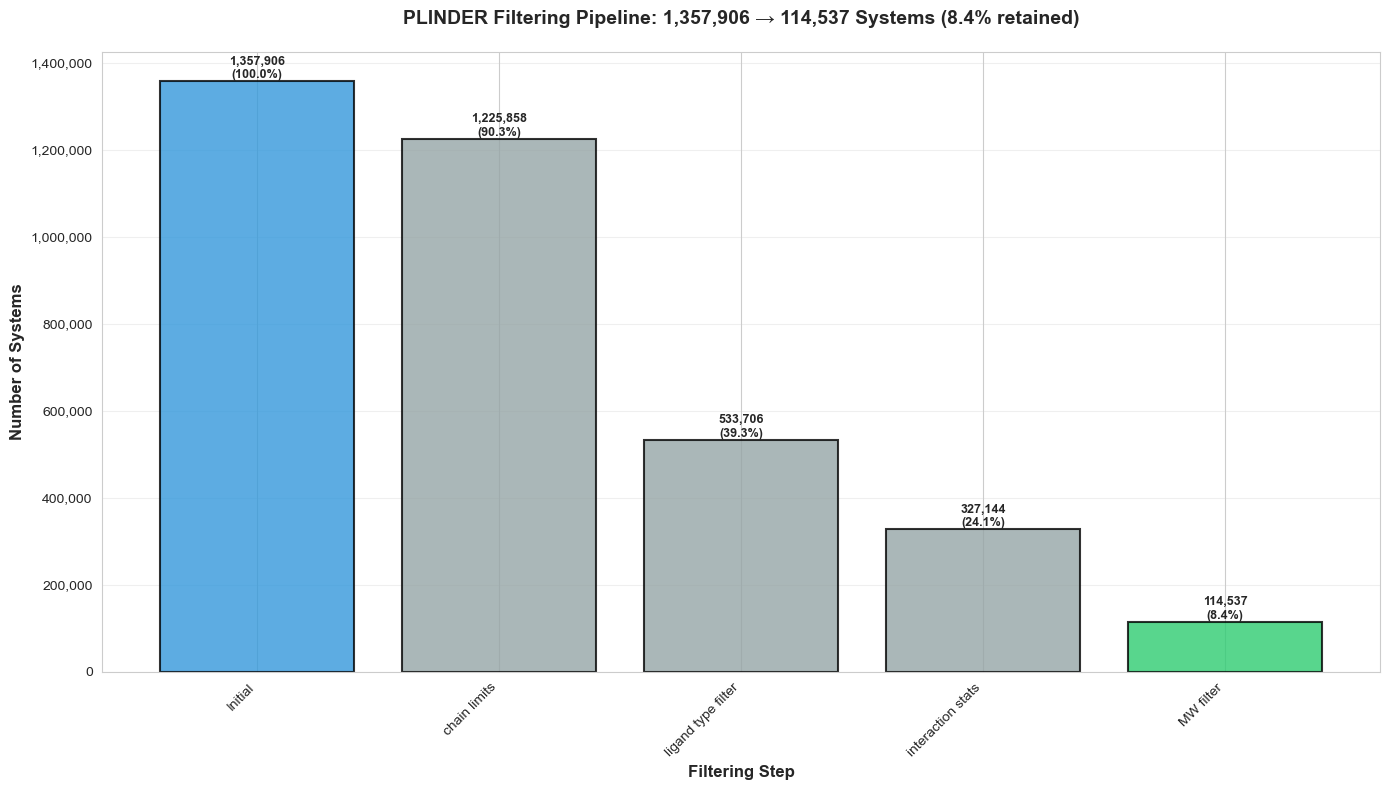

In [13]:
# Visualization 1: Waterfall chart
fig, ax = plt.subplots(figsize=(14, 8))

steps = list(filtering_stats.keys())
counts = list(filtering_stats.values())

# Create bar chart
bars = ax.bar(range(len(steps)), counts, color=['#3498db' if i == 0 else '#2ecc71' if i == len(steps)-1 else '#95a5a6' for i in range(len(steps))],
              edgecolor='black', linewidth=1.5, alpha=0.8)

# Add value labels
for i, (bar, count) in enumerate(zip(bars, counts)):
    height = bar.get_height()
    pct = (count / counts[0] * 100) if counts[0] > 0 else 0
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count:,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Formatting
ax.set_xticks(range(len(steps)))
ax.set_xticklabels([s.replace('After ', '') for s in steps], rotation=45, ha='right', fontsize=10)
ax.set_ylabel('Number of Systems', fontsize=12, fontweight='bold')
ax.set_xlabel('Filtering Step', fontsize=12, fontweight='bold')
ax.set_title(f'PLINDER Filtering Pipeline: {counts[0]:,} → {counts[-1]:,} Systems ({counts[-1]/counts[0]*100:.1f}% retained)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='y')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

plt.tight_layout()
plt.show()

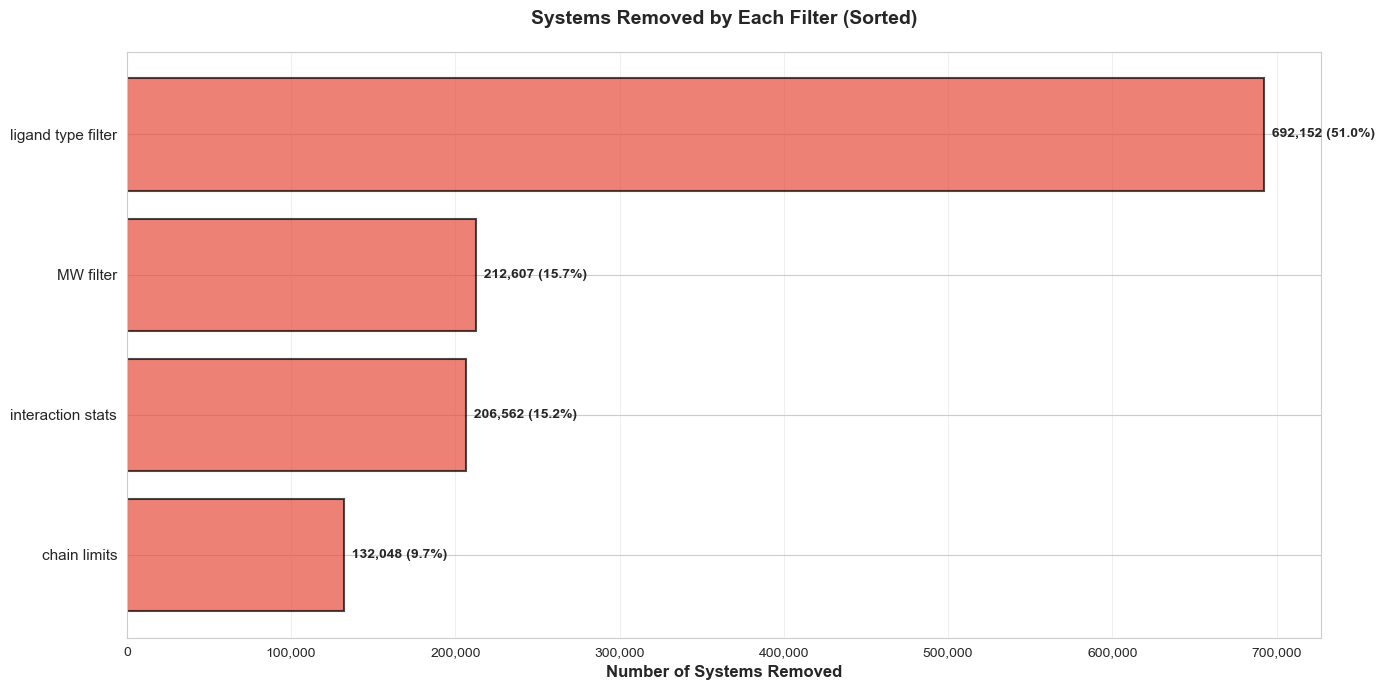

In [14]:
# Visualization 2: Systems removed at each step
fig, ax = plt.subplots(figsize=(14, 7))

removed_counts = []
removed_labels = []

for i in range(1, len(counts)):
    removed = counts[i-1] - counts[i]
    removed_counts.append(removed)
    removed_labels.append(steps[i].replace('After ', ''))

# Sort by removal count
sorted_data = sorted(zip(removed_counts, removed_labels), reverse=True)
removed_counts_sorted, removed_labels_sorted = zip(*sorted_data)

bars = ax.barh(range(len(removed_counts_sorted)), removed_counts_sorted, 
               color='#e74c3c', alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels
for i, (bar, count) in enumerate(zip(bars, removed_counts_sorted)):
    width = bar.get_width()
    pct = (count / counts[0] * 100) if counts[0] > 0 else 0
    ax.text(width, bar.get_y() + bar.get_height()/2.,
            f'  {count:,} ({pct:.1f}%)',
            ha='left', va='center', fontsize=10, fontweight='bold')

ax.set_yticks(range(len(removed_labels_sorted)))
ax.set_yticklabels(removed_labels_sorted, fontsize=11)
ax.set_xlabel('Number of Systems Removed', fontsize=12, fontweight='bold')
ax.set_title('Systems Removed by Each Filter (Sorted)', fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
ax.invert_yaxis()

plt.tight_layout()
plt.show()

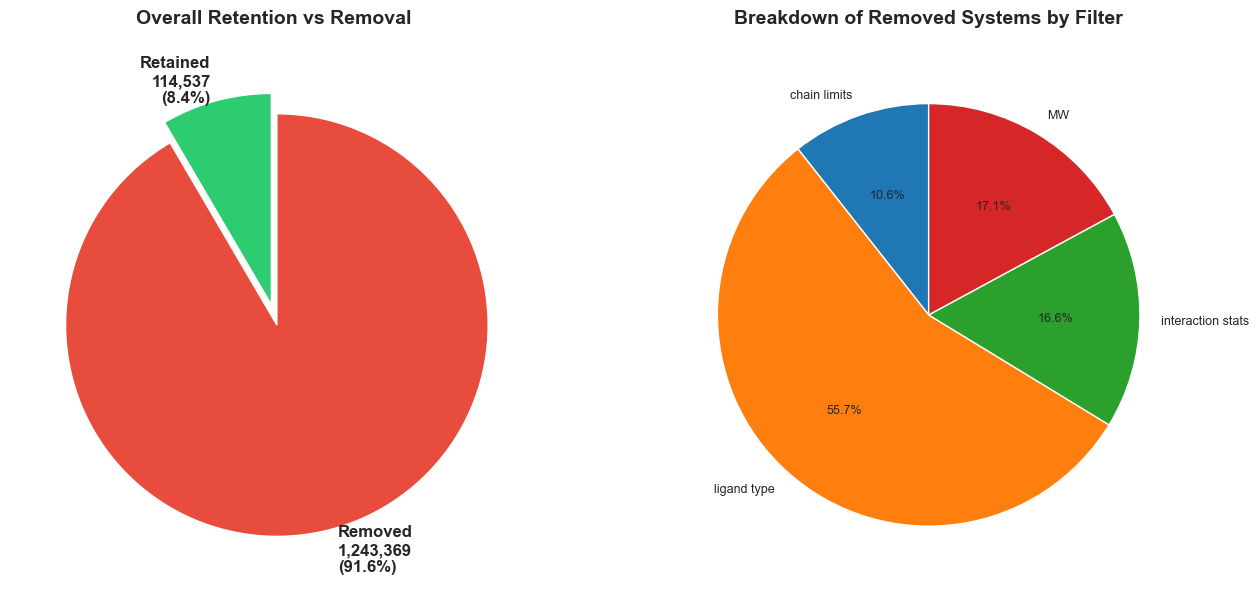

In [15]:
# Visualization 3: Pie chart of retention
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Overall retention
retained = counts[-1]
removed_total = counts[0] - counts[-1]
sizes = [retained, removed_total]
labels = [f'Retained\n{retained:,}\n({retained/counts[0]*100:.1f}%)', 
          f'Removed\n{removed_total:,}\n({removed_total/counts[0]*100:.1f}%)']
colors = ['#2ecc71', '#e74c3c']
explode = (0.05, 0.05)

ax1.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='',
        startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
ax1.set_title('Overall Retention vs Removal', fontsize=14, fontweight='bold', pad=20)

# Breakdown of removed systems by filter
removed_by_filter = []
filter_names = []
for i in range(1, len(counts)):
    removed = counts[i-1] - counts[i]
    if removed > 0:
        removed_by_filter.append(removed)
        filter_names.append(steps[i].replace('After ', '').replace(' filter', ''))

if removed_by_filter:
    ax2.pie(removed_by_filter, labels=filter_names, autopct='%1.1f%%',
            startangle=90, textprops={'fontsize': 9})
    ax2.set_title('Breakdown of Removed Systems by Filter', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

## Export Filtered Data

In [16]:
# Save filtered data
output_dir = Path('data')
output_dir.mkdir(parents=True, exist_ok=True)

# Save filtered annotation table
filtered_output = output_dir / 'annotation_table_filtered.parquet'
df.to_parquet(filtered_output, index=False)
print(f"✓ Saved filtered annotation table to: {filtered_output}")
print(f"  Shape: {df.shape}")
print(f"  Size: {filtered_output.stat().st_size / 1024**2:.2f} MB")

# Save filtering statistics
stats_output = output_dir / 'filtering_statistics.csv'
summary_df.to_csv(stats_output, index=False)
print(f"✓ Saved filtering statistics to: {stats_output}")

# Save text summary
summary_output = output_dir / 'filtering_summary.txt'
with open(summary_output, 'w') as f:
    f.write("="*80 + "\n")
    f.write("PLINDER SYSTEM FILTERING SUMMARY\n")
    f.write("="*80 + "\n\n")
    f.write(f"Initial systems: {counts[0]:,}\n")
    f.write(f"Final systems: {counts[-1]:,}\n")
    f.write(f"Total removed: {counts[0] - counts[-1]:,} ({(counts[0] - counts[-1])/counts[0]*100:.1f}%)\n")
    f.write(f"Retention rate: {counts[-1]/counts[0]*100:.1f}%\n\n")
    f.write("Filtering steps:\n")
    f.write("-"*80 + "\n")
    f.write(summary_df.to_string(index=False))
    f.write("\n" + "="*80 + "\n")

print(f"✓ Saved summary report to: {summary_output}")

print(f"\n{'='*80}")
print("EXPORT COMPLETE")
print(f"{'='*80}")

✓ Saved filtered annotation table to: data/annotation_table_filtered.parquet
  Shape: (114537, 743)
  Size: 159.72 MB
✓ Saved filtering statistics to: data/filtering_statistics.csv
✓ Saved summary report to: data/filtering_summary.txt

EXPORT COMPLETE


## Final Dataset Statistics

In [ ]:
# Display final dataset statistics
print("\n" + "="*80)
print("FINAL FILTERED DATASET STATISTICS")
print("="*80)

print(f"\nTotal systems: {len(df):,}")

# Count unique values in key columns
if 'system_id' in df.columns:
    print(f"Unique system IDs: {df['system_id'].nunique():,}")

# Check for PDB-related columns
pdb_cols = [col for col in df.columns if 'pdb' in col.lower()]
if pdb_cols:
    print(f"PDB-related columns: {pdb_cols}")
    if len(pdb_cols) > 0:
        print(f"Unique PDB entries: {df[pdb_cols[0]].nunique():,}")

# Resolution statistics (if available)
if 'resolution' in df.columns:
    print(f"\nResolution statistics:")
    print(f"  Min: {df['resolution'].min():.2f} Å")
    print(f"  Max: {df['resolution'].max():.2f} Å")
    print(f"  Mean: {df['resolution'].mean():.2f} Å")
    print(f"  Median: {df['resolution'].median():.2f} Å")

# Molecular weight statistics (if available)
mw_cols = [col for col in df.columns if 'molecular_weight' in col.lower() or 'mw' in col.lower()]
if mw_cols:
    col = mw_cols[0]
    print(f"\nMolecular weight statistics ({col}):")
    print(f"  Min: {df[col].min():.1f} Da")
    print(f"  Max: {df[col].max():.1f} Da")
    print(f"  Mean: {df[col].mean():.1f} Da")
    print(f"  Median: {df[col].median():.1f} Da")

# Interaction statistics (if available)
if 'num_plip_interactions' in df.columns or 'plip_interaction_count' in df.columns:
    col = 'num_plip_interactions' if 'num_plip_interactions' in df.columns else 'plip_interaction_count'
    print(f"\nPLIP interaction statistics:")
    print(f"  Min: {df[col].min()}")
    print(f"  Max: {df[col].max()}")
    print(f"  Mean: {df[col].mean():.1f}")
    print(f"  Median: {df[col].median():.1f}")

if 'num_pocket_residues' in df.columns or 'pocket_residue_count' in df.columns:
    col = 'num_pocket_residues' if 'num_pocket_residues' in df.columns else 'pocket_residue_count'
    print(f"\nPocket residue statistics:")
    print(f"  Min: {df[col].min()}")
    print(f"  Max: {df[col].max()}")
    print(f"  Mean: {df[col].mean():.1f}")
    print(f"  Median: {df[col].median():.1f}")

print("\n" + "="*80)
print(f"Preview of filtered data:")
print("="*80)
display(df.head(10))

print("\n✅ FILTERING PIPELINE COMPLETE!")
print(f"Filtered dataset ready for downstream analysis with {len(df):,} high-quality systems.")


FINAL FILTERED DATASET STATISTICS

Total systems: 60,983
Unique system IDs: 54,051
PDB-related columns: ['entry_pdb_id', 'entry_validation_pdbx_resolution', 'entry_validation_pdbx_reflns_resolution']
Unique PDB entries: 27,866

Molecular weight statistics (system_ligand_max_molecular_weight):
  Min: 200.0 Da
  Max: 1463.1 Da
  Mean: 465.0 Da
  Median: 438.2 Da

Preview of filtered data:
  Min: 200.0 Da
  Max: 1463.1 Da
  Mean: 465.0 Da
  Median: 438.2 Da

Preview of filtered data:


,entry_pdb_id,entry_release_date,entry_oligomeric_state,entry_determination_method,entry_keywords,entry_pH,entry_resolution,entry_validation_resolution,entry_validation_rfree,entry_validation_r,entry_validation_clashscore,entry_validation_percent_rama_outliers,entry_validation_percent_rota_outliers,entry_validation_data_completeness,entry_validation_percent_RSRZ_outliers,entry_validation_atom_count,entry_validation_molprobity,entry_validation_mean_b_factor,entry_validation_median_b_factor,entry_validation_pdbx_resolution,entry_validation_pdbx_reflns_resolution,entry_validation_meanI_over_sigI_obs,entry_validation_r_minus_rfree,entry_pass_validation_criteria,system_biounit_id,system_protein_chains_asym_id,system_id_no_biounit,system_ligand_chains,system_num_pocket_residues,system_proper_num_pocket_residues,system_num_interactions,system_proper_num_interactions,system_num_unique_interactions,system_proper_num_unique_interactions,system_num_covalent_ligands,system_proper_num_covalent_ligands,system_id,system_type,system_has_kinase_inhibitor,system_has_binding_affinity,system_num_protein_chains,system_proper_num_protein_chains,system_num_ligand_chains,system_proper_num_ligand_chains,system_num_crystal_contacted_residues,system_num_atoms_with_crystal_contacts,system_num_heavy_atoms,system_num_resolved_heavy_atoms,system_ligand_max_qed,system_ligand_max_molecular_weight,...,protein_seqsim_weighted_max__100__community,protein_seqsim_weighted_max__70__weak__component,protein_seqsim_weighted_max__95__weak__component,protein_seqsim_weighted_max__100__weak__component,protein_seqsim_weighted_max__70__strong__component,protein_seqsim_weighted_max__95__strong__component,protein_seqsim_weighted_max__100__strong__component,protein_seqsim_weighted_sum__50__community,protein_seqsim_weighted_sum__70__community,protein_seqsim_weighted_sum__95__community,protein_seqsim_weighted_sum__100__community,protein_seqsim_weighted_sum__50__weak__component,protein_seqsim_weighted_sum__70__weak__component,protein_seqsim_weighted_sum__95__weak__component,protein_seqsim_weighted_sum__100__weak__component,protein_seqsim_weighted_sum__50__strong__component,protein_seqsim_weighted_sum__70__strong__component,protein_seqsim_weighted_sum__95__strong__component,protein_seqsim_weighted_sum__100__strong__component,tanimoto_similarity_max__30__community,tanimoto_similarity_max__50__community,tanimoto_similarity_max__70__community,tanimoto_similarity_max__95__community,tanimoto_similarity_max__100__community,tanimoto_similarity_max__30__weak__component,tanimoto_similarity_max__50__weak__component,tanimoto_similarity_max__70__weak__component,tanimoto_similarity_max__95__weak__component,tanimoto_similarity_max__100__weak__component,tanimoto_similarity_max__30__strong__component,tanimoto_similarity_max__50__strong__component,tanimoto_similarity_max__70__strong__component,tanimoto_similarity_max__95__strong__component,tanimoto_similarity_max__100__strong__component,uniqueness,biounit_num_ligands,biounit_num_unique_ccd_codes,biounit_num_proper_ligands,system_ligand_has_lipinski,system_ligand_has_cofactor,system_ligand_has_fragment,system_ligand_has_oligo,system_ligand_has_artifact,system_ligand_has_other,system_ligand_has_covalent,system_ligand_has_invalid,system_ligand_has_ion,system_protein_chains_total_length,system_unique_ccd_codes,system_proper_unique_ccd_codes
14,4grc,2012-08-24,dimeric,X-RAY DIFFRACTION,OXIDOREDUCTASE,,2.000000,2.00,0.1975,0.1594,1.63,0.00,2.19,99.98,0.56,3200.0,1.170623,24.229779,21.940001,2.000000,2.000,4.28,0.0381,True,1,[1.A],4grc__A__C_D,"[1.C, 1.D]",43,35,37,33,32,29,0,0,4grc__1__1.A__1.C_1.D,holo,False,False,1,1,2,1,0,0,45,45,0.416598,616.177293,...,c1,c0,c0,c0,c0,c0,c0,c0,c1,c1,c2,c0,c0,c0,c0,c0,c0,c0,c0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,4grc__A__C_D_c118167,6,3,2,True,True,True,False,True,False,False,False,False,440,HEM-PEO,HEM
16,4grc,2012-08-24,dimeric,X-RAY DIFFRACTION,OXIDOREDUCTASE,,2.000000,2.00,0.


✅ FILTERING PIPELINE COMPLETE!
Filtered dataset ready for downstream analysis with 60,983 high-quality systems.


: 